<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/photocircuit_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils and Imports

In [7]:
def draw_image(image, figsize=(12, 16)):
  plt.figure(figsize=figsize)
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()

def create_white_image(image):

    # Get the dimensions of the input image
    height, width = image.shape
    channels = 1

    # Create an all-white image with the same dimensions as the input image
    return np.ones((height, width, channels), dtype=np.uint8) * 255

def apply_n_times(func, times, input):
  if times == 1:
    return func(input)
  else:
    return func(apply_n_times(func, times-1, input))


In [8]:
!apt-get install -y poppler-utils
!pip install PyPDF2 pytesseract pdf2image opencv-python-headless
!pip install pytesseract
!apt install tesseract-ocr
!apt install libtesseract-dev


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.4 [186 kB]
Fetched 186 kB in 1s (227 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121925 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.4_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.4) ...
Setting up poppler-utils (22.02.0-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.1 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The follow

In [9]:
from PyPDF2 import PdfReader
import cv2
import pytesseract
from pdf2image import convert_from_path
import os
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import math

In [10]:
CIRCUITS_RAW_DIRECTORY = '/content/drive/MyDrive/Photo_Circuit/data/circuits_raw'
CIRCUITS_TEXTBOOK_LOC = '/content/drive/MyDrive/Photo_Circuit/data/Fundamentals_of_Electric_Circuits_6th_Sadiku.pdf'

# Part 1. Extract Closeup of every potential circuit

### Save as Images

In [7]:
from google.colab import drive
drive.mount('/content/drive')

def convert_pdf_to_images(pdf_path, start_page, end_page):
    images = []
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        for page_num in range(start_page - 1, end_page):
            if reader.is_encrypted:
                reader.decrypt('')
            page = reader.pages[page_num]
            images += convert_from_path(pdf_path, first_page=page_num + 1, last_page=page_num + 1, fmt='jpeg')
    return images

# pages_all = convert_pdf_to_images(book_pdf_path, 390, 575)
pages_pil = convert_pdf_to_images(CIRCUITS_TEXTBOOK_LOC, 462, 476)
images = [np.array(pil_image) for pil_image in pages_pil]  # Convert PIL images to NumPy arrays
pages = [cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) if image.ndim == 2 else image for image in images]  # Convert grayscale images to BGR


Mounted at /content/drive


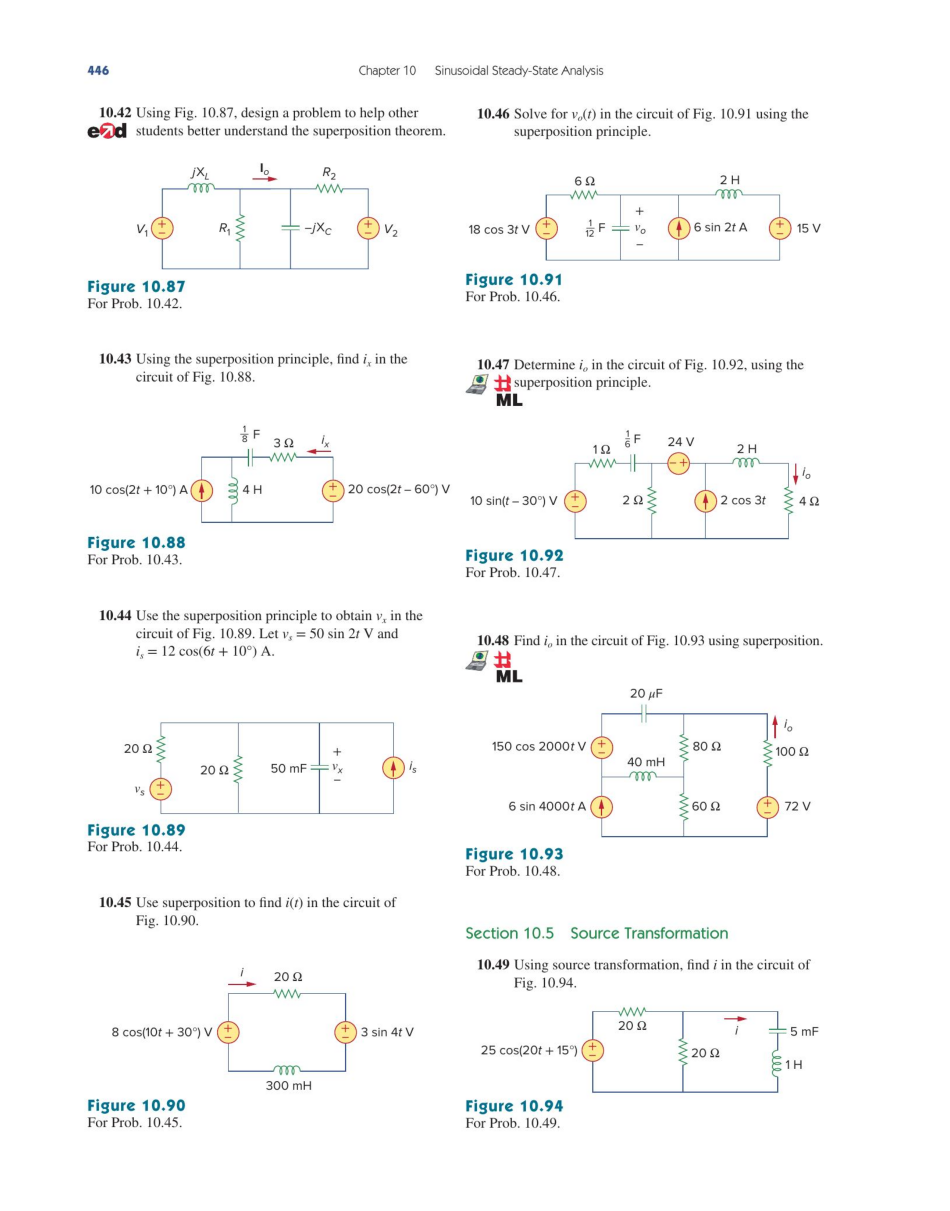

In [9]:
# Assuming you have already run the main() function
TEST_PAGE = 7
first_page_image = pages_pil[TEST_PAGE]
draw_image(first_page_image)

### Get Contours

In [10]:
def find_contours(image, kernel_size=3, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (kernel_size, kernel_size), 0)

    # Perform Sobel edge detection
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    sobel_magnitude = np.uint8(sobel_magnitude / np.max(sobel_magnitude) * 255)

    # Threshold the Sobel magnitude to create a binary image
    _, binary_image = cv2.threshold(sobel_magnitude, threshold, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours

contours = [find_contours(page) for page in pages]

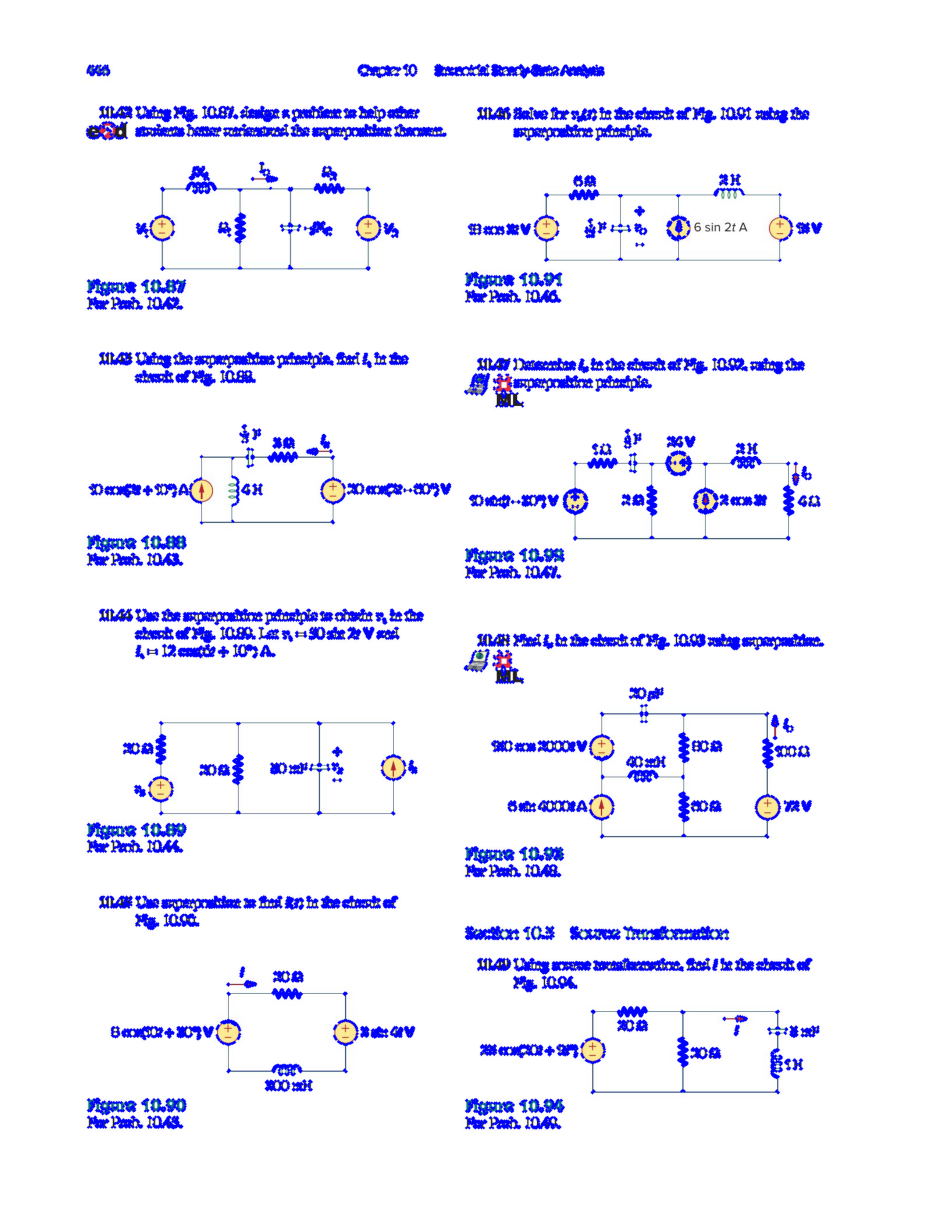

In [11]:
image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
for contour in contours[TEST_PAGE]:
    for point in contour:
        x, y = point[0]
        cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
draw_image(image_with_dots)

## Get Bounding Boxes

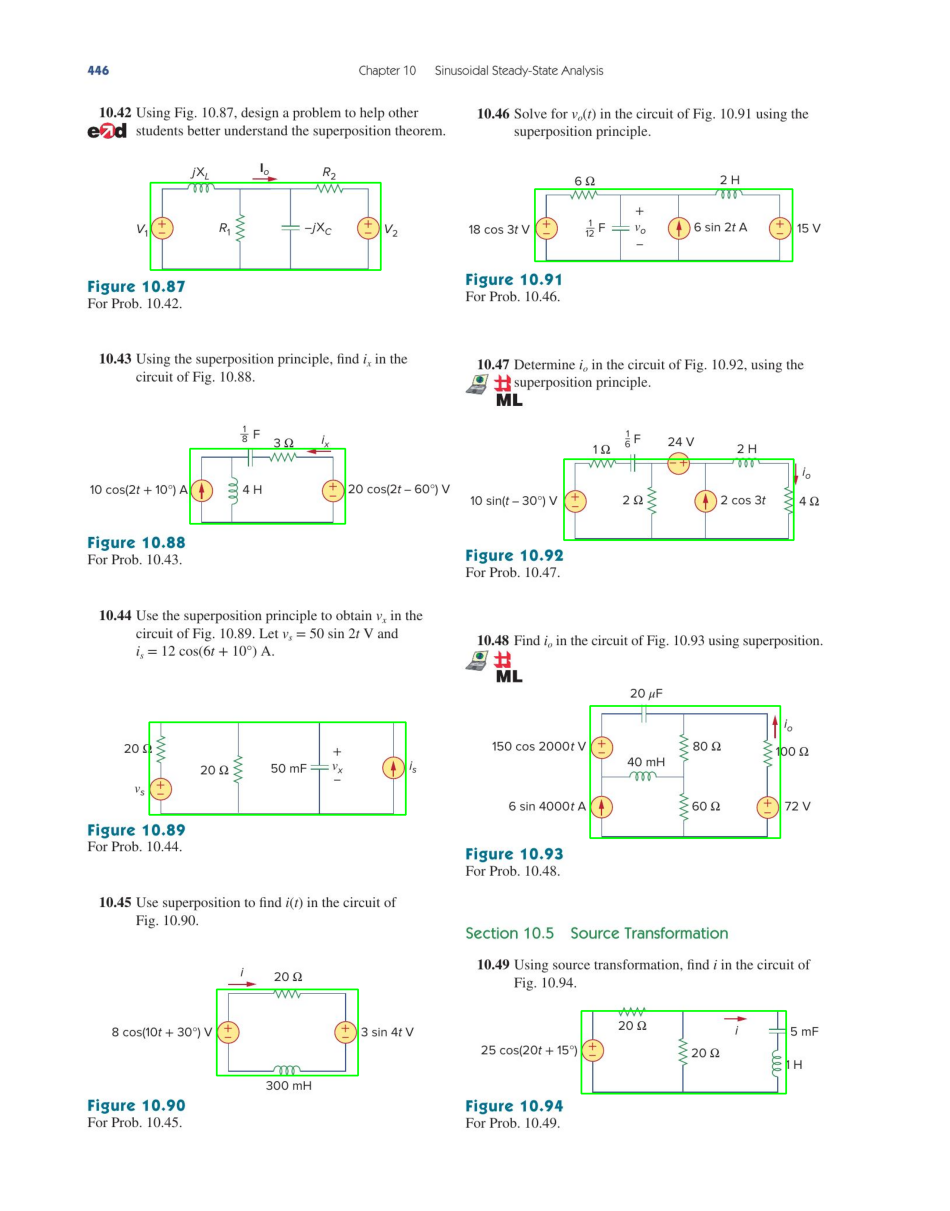

In [12]:
def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    return image_with_boxes

def get_bounding_boxes(contours, min_length):
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        if w < min_length or h < min_length:
          continue

        yield (x, y, w, h)


min_length = images[0].shape[1] * 0.05
bounding_boxes = [list(get_bounding_boxes(contour, min_length)) for contour in contours]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes[i]) for i in range(len(images))]

draw_image(images_with_boxes[TEST_PAGE])


### Remove Overlapping Bounding Boxes

In [13]:
import copy

def intervals_overlap(intr1, intr2, reversed_call=False):
  # intr1: -------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr2[0] < intr1[1]:
    return True
  # intr1:  -----------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr1[1] > intr2[1]:
    return True

  if not reversed_call:
    return intervals_overlap(intr2, intr1, True)
  else:
    return False

def get_intervals_for_rect(rect):
  x, y, w, h = rect
  xintr = (x, x + w)
  yintr = (y, y + h)
  return xintr, yintr

def merge_rects(rect1, rect2):
  x1, y1, w1, h1 = rect1
  x2, y2, w2, h2 = rect2

  right1 = x1 + w1
  top1 = y1 + h1
  right2 = x2 + w2
  top2 = y2 + h2

  xn = min(x1, x2)
  yn = min(y1, y2)

  rightn = max(right1, right2)
  topn = max(top1, top2)

  wn = rightn - xn
  hn = topn - yn
  return xn, yn, wn, hn

def combine_overlapping_rects(rectangles_input):
    found_overlap = True
    overlapping_indexes = (-1,-1)
    rectangles = copy.deepcopy(rectangles_input)
    while found_overlap:
      found_overlap = False
      for i, rect1 in enumerate(rectangles):
        xintr1, yintr1 = get_intervals_for_rect(rect1)
        for j, rect2 in enumerate(rectangles):
          xintr2, yintr2 = get_intervals_for_rect(rect2)

          if intervals_overlap(xintr1, xintr2) and intervals_overlap(yintr1, yintr2):
            found_overlap = True
            overlapping_indexes = (i, j)
            break
        if found_overlap:
          break

      if found_overlap:
        idx1, idx2 = overlapping_indexes
        rect1 = rectangles[idx1]
        rect2 = rectangles[idx2]
        rectn = merge_rects(rect1, rect2)
        rectangles = [x for i, x in enumerate(rectangles) if i not in overlapping_indexes]
        rectangles.append(rectn)
    return rectangles

bounding_boxes_page = bounding_boxes[TEST_PAGE]
combine_overlapping_rects(bounding_boxes_page)


[(982, 1721, 352, 142),
 (355, 1684, 243, 148),
 (239, 1225, 441, 159),
 (997, 1197, 327, 227),
 (952, 773, 395, 139),
 (309, 755, 267, 129),
 (902, 309, 443, 124),
 (241, 298, 396, 150)]

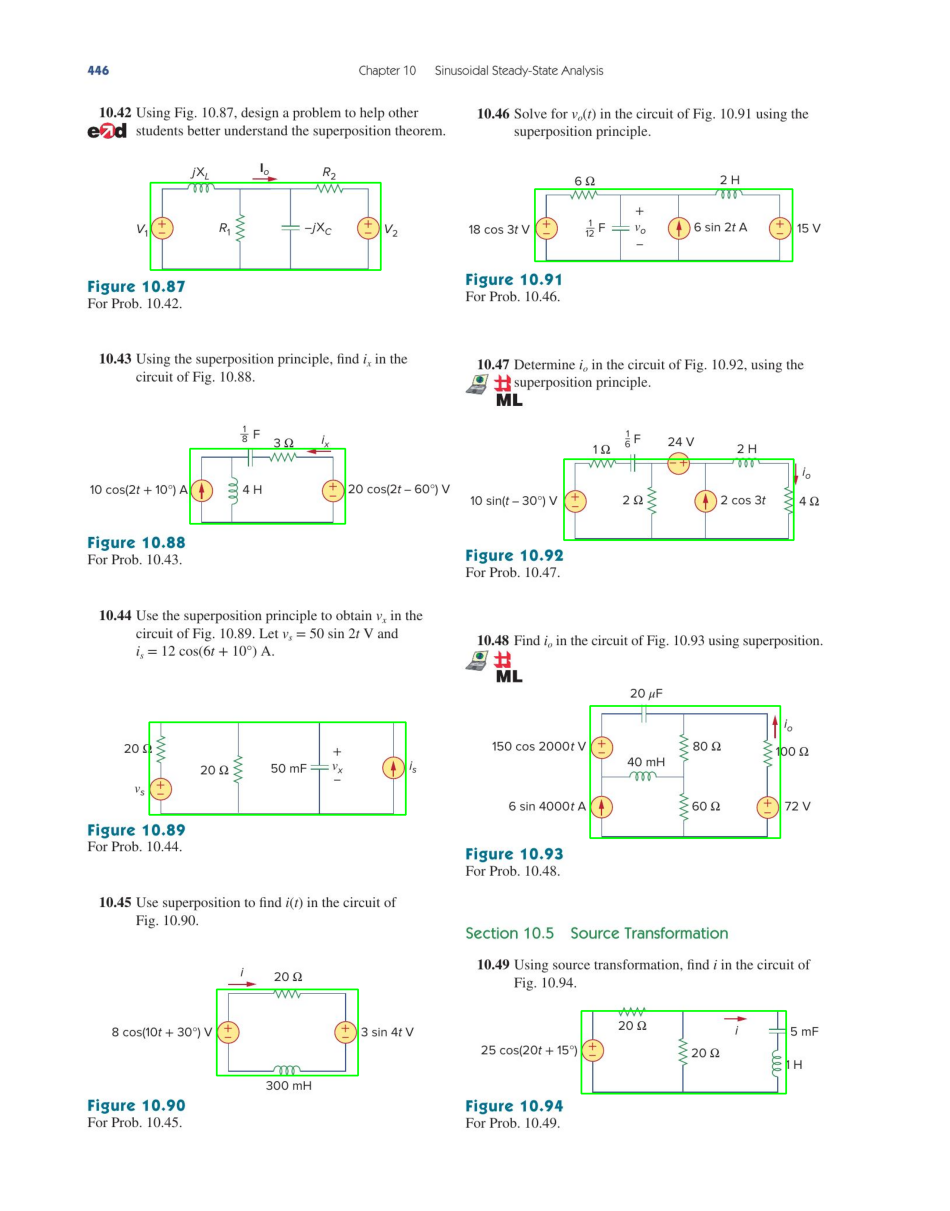

In [15]:
bounding_boxes_no_ol = [combine_overlapping_rects(list(bounding_boxes_i)) for bounding_boxes_i in bounding_boxes]
images_with_boxes = [draw_bounding_boxes(images[i], bounding_boxes_no_ol[i]) for i in range(len(images))]
draw_image(images_with_boxes[TEST_PAGE])

## Expand bounding boxes to capture unit labels

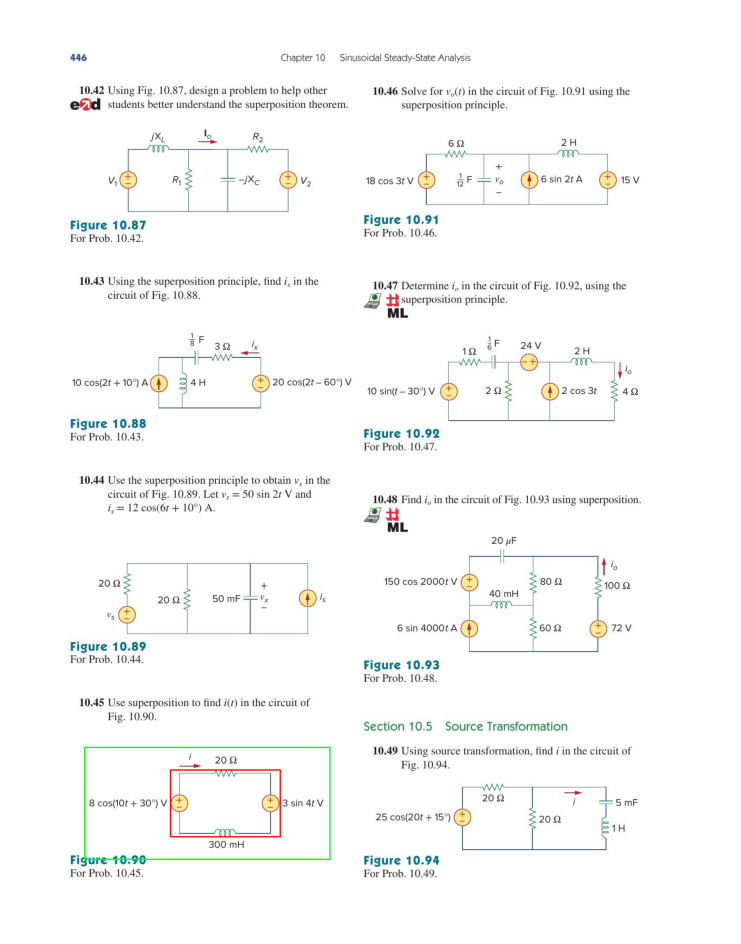

In [16]:
def get_potential_points_around_bounding_box(bounding_box, contours, max_size):
  x, y, w, h = bounding_box
  x -= max_size
  y -= max_size
  w += 2 * max_size
  h += 2 * max_size

  res = []
  for contour in contours:
    for point in contour:
      px, py = point[0]
      if (x <= px < x + w) and (y <= py < y + h):
        res += [(px, py)]
  return res

def find_points_not_in_box(bounding_box, points):
  x, y, w, h = bounding_box
  new_points = [
      (px, py)
      for px, py in points
      if not ((x <= px < x + w) and (y <= py < y + h))
  ]
  return new_points

def expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding):
  # global images
  # Find all points that it is possible for this process to reach
  max_expansion_for_box = step_size * max_steps
  potential_points = get_potential_points_around_bounding_box(
      bounding_box, contours, max_expansion_for_box
  )

  #  Uncomment to show image with potential points and bounding box labeled
  # image_with_dots = images[1].copy()
  # dot_radius=2
  # color=(0, 0, 255)
  # for point in potential_points:
  #   x, y = point
  #   cv2.circle(image_with_dots, (x, y), dot_radius, color, -1)
  # xb, yb, wb, hb = bounding_box
  # cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
  # draw_image(image_with_dots)

  # Expand each surface as number of points captured increases
  right_transform = lambda x, y, w, h: (x, y, w + step_size, h)
  up_transform    = lambda x, y, w, h: (x, y, w, h + step_size)
  left_transform  = lambda x, y, w, h: (x - step_size, y, w + step_size, h)
  down_transform  = lambda x, y, w, h: (x, y - step_size, w, h + step_size)
  transforms = [
      right_transform,
      up_transform,
      left_transform,
      down_transform
  ]
  x, y, w, h = bounding_box
  points_not_in_box = find_points_not_in_box((x, y, w, h), potential_points)
  for transform in transforms:
    for _ in range(max_steps):
      xn, yn, wn, hn = transform(x, y, w, h)
      new_points_not_in_box = find_points_not_in_box((xn, yn, wn, hn), points_not_in_box)
      if len(new_points_not_in_box) == len(points_not_in_box):
        break
      else:
        points_not_in_box = new_points_not_in_box
        x, y, w, h = xn, yn, wn, hn

  x -= fixed_padding
  y -= fixed_padding
  w += 2 * fixed_padding
  h += 2 * fixed_padding

  return x, y, w, h

step_size = 20
max_steps = 20
fixed_padding = 10
max_expansion_for_box = step_size * max_steps

bounding_box = expand_bounding_box(bounding_boxes_no_ol[TEST_PAGE][1], contours[TEST_PAGE], step_size, max_steps, fixed_padding)

image_with_dots = images[TEST_PAGE].copy()
dot_radius=2
color=(0, 0, 255)
xb, yb, wb, hb = bounding_boxes_no_ol[TEST_PAGE][1]
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (255, 0, 0), 2)
xb, yb, wb, hb = bounding_box
cv2.rectangle(image_with_dots, (xb, yb), (xb + wb, yb + hb), (0, 255, 0), 2)
draw_image(image_with_dots, figsize=(16, 12))

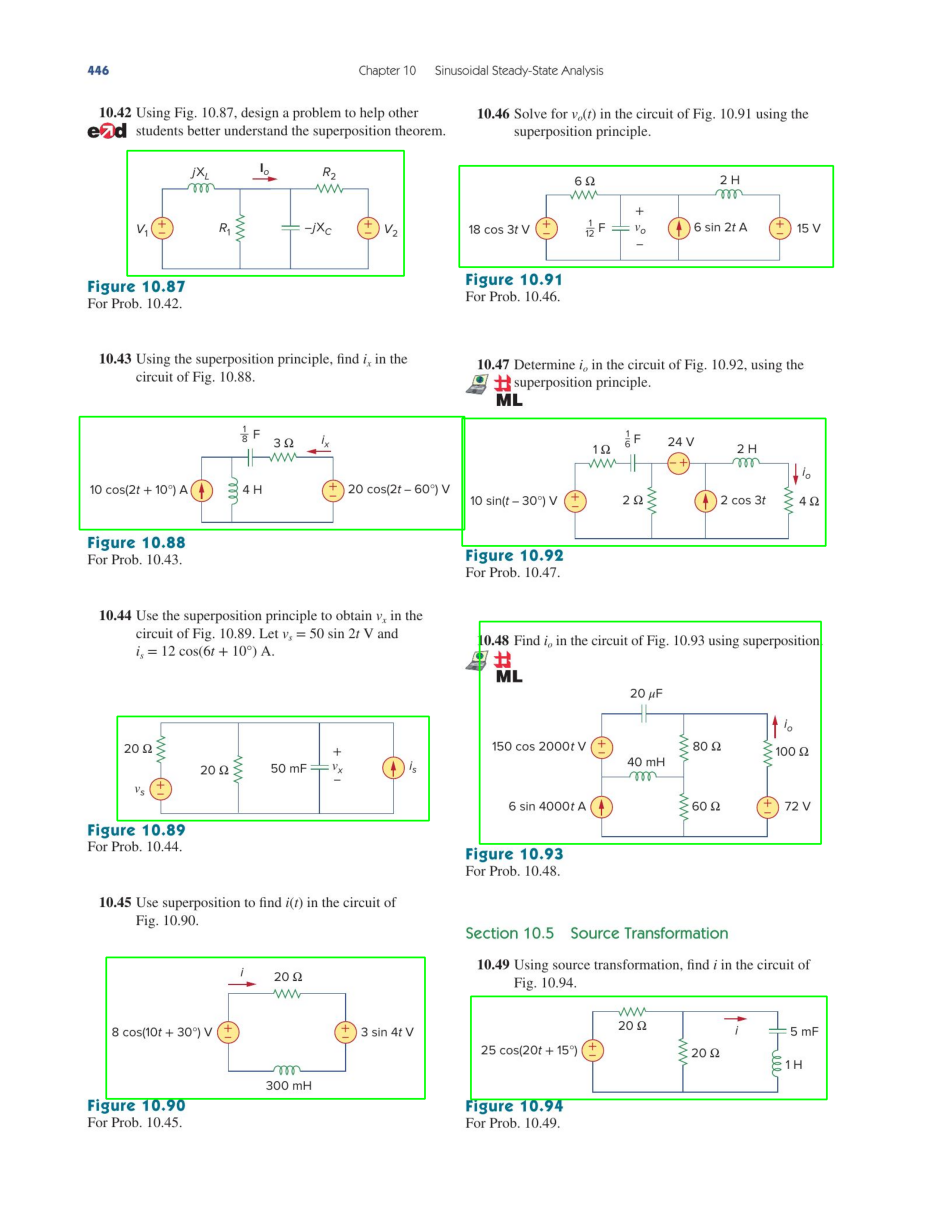

In [17]:
def expand_bounding_boxes(bounding_boxes, contours, step_size, max_steps, fixed_padding = 10):
  return [
      expand_bounding_box(bounding_box, contours, step_size, max_steps, fixed_padding)
      for bounding_box in bounding_boxes
  ]

max_steps = 20
step_size = 15
fixed_padding = 10
bounding_boxes_expanded = [
    expand_bounding_boxes(bounding_boxes_i, contours_i, step_size, max_steps, fixed_padding)
    for bounding_boxes_i, contours_i in zip(bounding_boxes_no_ol, contours)
]
image_with_box = draw_bounding_boxes(images[TEST_PAGE], bounding_boxes_expanded[TEST_PAGE])
draw_image(image_with_box)

## Extract circuit closeups from bounding boxes and export

In [18]:
import cv2
import os
import shutil

# Remove the directory and its contents if it exists
if os.path.exists(CIRCUITS_RAW_DIRECTORY):
    shutil.rmtree(CIRCUITS_RAW_DIRECTORY)

# Create a directory to store the close-ups
os.makedirs(CIRCUITS_RAW_DIRECTORY, exist_ok=True)

circuit_images = []
for i, (bounding_boxes, image) in enumerate(zip(bounding_boxes_expanded, images)):
  for j, (x, y, w, h) in enumerate(bounding_boxes):
      circuit_closeup = image[y:y + h, x:x + w]
      circuit_closeup = cv2.cvtColor(circuit_closeup, cv2.COLOR_BGR2GRAY)
      close_up_filename = f'{CIRCUITS_RAW_DIRECTORY}/circuit_page_{i}_circuit_{j}.png'
      cv2.imwrite(close_up_filename, circuit_closeup)
      circuit_images.append(circuit_closeup)

# Part 2. Find Components in circuit

### Define Models

In [11]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Component:
  name: str
  bbox: Tuple[int, int, int, int]
  id: str

@dataclass
class Node:
  id: str
  ports: list[Tuple[str, int]]

## Load Circuits from Drive

In [12]:
import cv2
import os
import glob

from google.colab import drive
drive.mount('/content/drive')

# Get a list of all image file paths in the directory
CIRCUITS_RAW_DIRECTORY = '/content/drive/MyDrive/Photo_Circuit/data/circuits_raw'
image_paths = glob.glob(os.path.join(CIRCUITS_RAW_DIRECTORY, '*.png'))

# Load all images into an array
raw_circuit_images = [cv2.imread(image_path) for image_path in image_paths]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


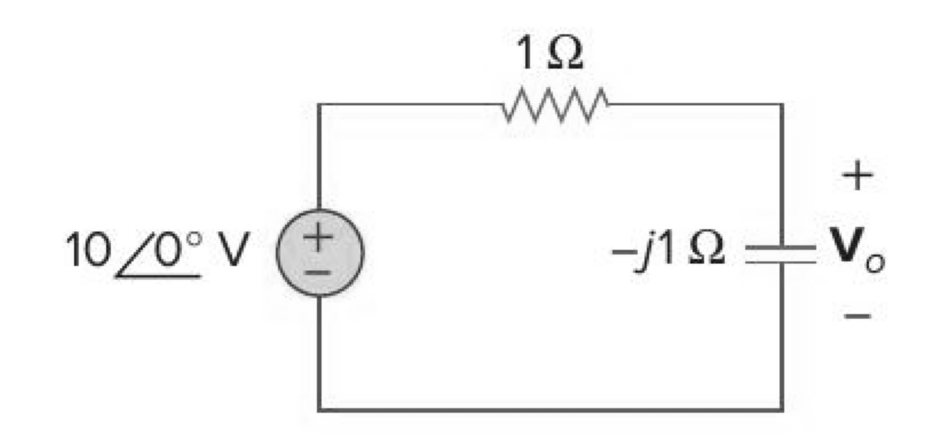

In [13]:
TEST_CIRCUIT = 1

MIN_CONTOUR_LENGTH_ALL = 80
MIN_CONTOUR_LENGTH_VERT = 80
MIN_CONTOUR_LENGTH_HORZ = 80

MAX_CAP_CONTOUR_LENGTH_ALL = 30

WIRE_ANGLE_COSINE_THRESHOLD = 0.0001
WIRE_AVG_POINTS = 2

draw_image(raw_circuit_images[TEST_CIRCUIT])

## Preprocessing


### Testing Tessaract

12
+
10
70°
V


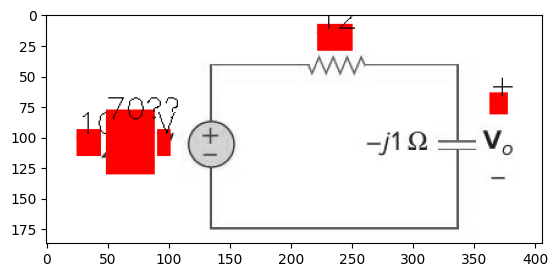

In [14]:
import cv2
import numpy as np
import pytesseract
from pytesseract import Output

# Load your image
image = raw_circuit_images[TEST_CIRCUIT].copy()

# Use Tesseract to get the bounding boxes of all text in the image
d = pytesseract.image_to_data(image, output_type=Output.DICT, config='--psm 6 -l eng+ell')

# Go through all detected text
n_boxes = len(d['text'])
for i in range(n_boxes):
# for i in [2]:
    # Ignore text that doesn't meet a certain confidence threshold
    if int(d['conf'][i]) > 10:
        print(d['text'][i])
        if d['text'][i] in ['-', '=', '=']:
          continue

        ih, iw, ic = image.shape

        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        if w > iw * 0.1:
          w = w//2

        padding_w = int(0.01 * w)
        padding_h = int(0.2 * h)
        cv2.rectangle(image, (x - padding_w, y - padding_h), (x + w + padding_w, y + h + padding_h), (255, 0, 0), thickness=-1)

        cv2.putText(img=image, text=d['text'][i], org=(x, y),
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.8,
                    color=(0),
                    thickness=1)

# # Use Tesseract to get the bounding boxes of all characters in the image
# boxes = pytesseract.image_to_boxes(image)

# # Go through all detected characters
# for b in boxes.splitlines():
#     b = b.split(' ')
#     character = b[0]
#     if character.isalnum():  # this will exclude spaces and other non-alphanumeric characters
#         (x, y, w, h) = (int(b[1]), int(b[2]), int(b[3]), int(b[4]))
#         cv2.rectangle(image, (x, image.shape[0] - y), (w, image.shape[0] - h), (0, 0, 255), thickness=-1)


# Now we apply inpainting to remove the text
# result = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

plt.imshow(image)


### Filter out text of circuits


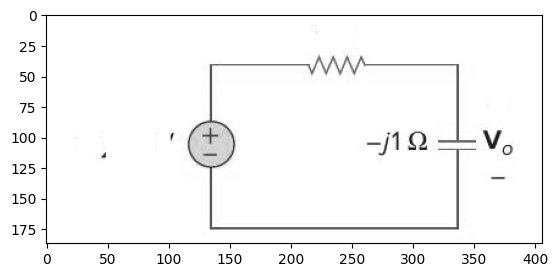

In [15]:
def filter_text_from_circuit_image(circuit_image):
  circuit_image_no_text = circuit_image.copy()

  # Use Tesseract to get the bounding boxes of all text in the image
  d = pytesseract.image_to_data(circuit_image_no_text, output_type=Output.DICT, config='--psm 6 -l eng+ell')

  # Go through all detected text
  n_boxes = len(d['text'])
  for i in range(n_boxes):
  # for i in [2]:
      # Ignore text that doesn't meet a certain confidence threshold
      if int(d['conf'][i]) > 5:

          (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])

          # If the width of the text is > X% of image width it is probably also covering a component
          # only look at left half
          ih, iw, ic = image.shape
          if w > iw * 0.1:
            w = w//2

          padding_w = int(0.01 * w)
          padding_h = int(0.2 * h)
          cv2.rectangle(circuit_image_no_text, (x - padding_w, y - padding_h), (x + w + padding_w, y + h + padding_h), (255, 255, 255), thickness=-1)

          ##### For Testing
          # cv2.putText(img=image, text=d['text'][i], org=(x, y),
          #             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
          #             fontScale=0.8,
          #             color=(0),
          #             thickness=1)
  return circuit_image_no_text

circuit_images_no_text = list(map(filter_text_from_circuit_image, raw_circuit_images))

plt.imshow(circuit_images_no_text[TEST_CIRCUIT])

## finally set circuit_images to results of preprocessing

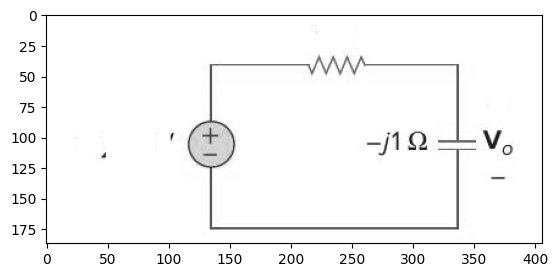

In [16]:
circuit_images = circuit_images_no_text
plt.imshow(circuit_images[TEST_CIRCUIT])

## Apply Vertical and Horizontal Filters


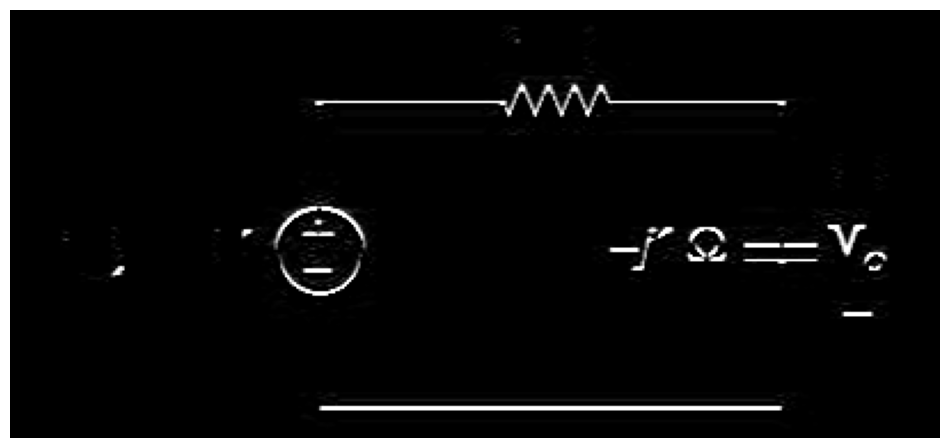

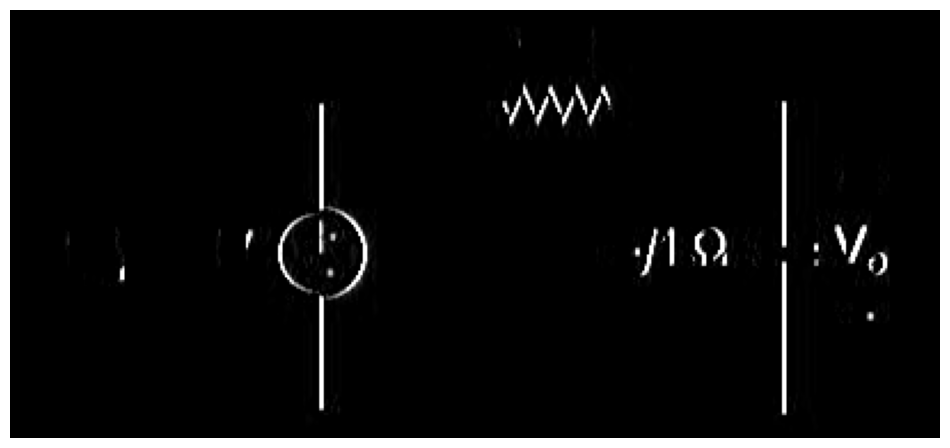

In [17]:
def horz_kernal(image):
  if len(image.shape) == 3 and image.shape[2] > 1:
      # Convert the image to grayscale if it has 3 or 4 channels
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      # If the image is already grayscale, use it directly
      gray_image = image

  # Define a kernel (example: 5x5 Gaussian blur kernel)
  kernel = np.array([
      [1, 2, 1],
      [0, 0, 0],
      [-1, -2, -1],
  ])

  # Apply the kernel to the image
  return cv2.filter2D(gray_image, -1, kernel)

def vert_kernal(image):
  if len(image.shape) == 3 and image.shape[2] > 1:
      # Convert the image to grayscale if it has 3 or 4 channels
      gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      # If the image is already grayscale, use it directly
      gray_image = image

  # Define a kernel (example: 5x5 Gaussian blur kernel)
  kernel = np.array([
      [-1, 0, 1],
      [-1, 0, 1],
      [-1, 0, 1],
  ])

  # Apply the kernel to the image
  return cv2.filter2D(gray_image, -1, kernel)

circuit_images_horz = list(map(horz_kernal, circuit_images))
circuit_images_vert = list(map(vert_kernal, circuit_images))

draw_image(circuit_images_horz[TEST_CIRCUIT])
draw_image(circuit_images_vert[TEST_CIRCUIT])

## Get Contours for wires in circuits



<Figure size 640x480 with 0 Axes>

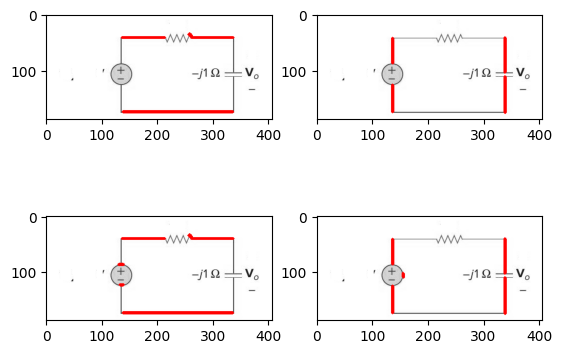

In [27]:
def find_contours_plain(image):

    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours = list(filter(
        lambda c: c.shape[0] > MIN_CONTOUR_LENGTH_ALL,
        contours
    ))

    return contours

def slope_to_angle(slope):
    # Handle the case where the slope is infinity (vertical line)
    if slope == float("inf") or slope == float("-inf"):
        return 90  # The angle of a vertical line is 90 degrees
    # Handle the case where the slope is 0 (horizontal line)
    elif slope == 0:
        return 0   # The angle of a horizontal line is 0 degrees
    else:
        # Compute the angle in degrees for other cases.
        # math.atan returns the arc tangent of slope in radians.
        # math.degrees converts it to degrees.
        return math.degrees(math.atan(slope))

def cosine_difference(angle1, angle2):
    # Convert angles from degrees to radians
    angle1_rad = math.radians(angle1)
    angle2_rad = math.radians(angle2)

    # Compute cosine difference
    cos_diff = math.cos(angle1_rad) * math.cos(angle2_rad) + math.sin(angle1_rad) * math.sin(angle2_rad)
    return cos_diff

# target_angle -> desired angle of wires in degrees
# cosine_angle_threshold -> max cosine difference between target and measdured angle to not filter out line
def filter_contours_by_slope(contours, target_angle, cosine_angle_threshold, n):
    horizontal_contours_list = []

    ## For Testing
    # slopes = []
    # angles = []

    for contour in contours:
        horizontal_points = []
        i = 0
        while i < len(contour) - 2 * n:
            avg_pt1 = np.mean(contour[i:i + n], axis=0)[0]
            avg_pt2 = np.mean(contour[i + n:i + 2 * n], axis=0)[0]

            # Calculate the slope of the line segment between avg_pt1 and avg_pt2
            if avg_pt2[0] != avg_pt1[0]:
                slope = (avg_pt2[1] - avg_pt1[1]) / (avg_pt2[0] - avg_pt1[0])
            else:
                slope = float("inf")

            angle = slope_to_angle(slope)

            # For Testing
            # slopes += [slope]
            # angles += [angle]

            # Use ABS since we dont care about the direction of the wire
            cosine_dif = abs(cosine_difference(angle, target_angle))

            # Check if the slope is within the threshold
            if ((1 - cosine_dif) <= cosine_angle_threshold):
                horizontal_points.extend(contour[i:i + 2 * n].tolist())
                i += n
            else:
                i += 2 * n

        if horizontal_points:
            horizontal_contours_list.append(np.array(horizontal_points))

    # TODO Testing
    # plt.plot(slopes)
    # plt.plot(angles)

    return horizontal_contours_list

def filter_wires_by_slope(images, target_angle, min_length, max_length = 10000000):
  # utility to filter out contours under specified length
  filter_small_contours = lambda contours_circuit: \
    list(filter(
      lambda x: (len(x) >= min_length) and (len(x) < max_length),
      contours_circuit
    ))

  contours = list(map(find_contours_plain, images))
  contours_aligned = list(map(
      partial(
          filter_contours_by_slope,
          target_angle=target_angle,
          cosine_angle_threshold=WIRE_ANGLE_COSINE_THRESHOLD,
          n=WIRE_AVG_POINTS
      ),
      contours
  ))
  contours_aligned_min_length = list(map(
      filter_small_contours,
      contours_aligned
  ))
  return contours_aligned_min_length

# Horizontal processing
contours_horz = filter_wires_by_slope(
    images=circuit_images_horz,
    target_angle=0,
    min_length=MIN_CONTOUR_LENGTH_HORZ
)

# Vertical Processing
contours_vert = filter_wires_by_slope(
    images=circuit_images_vert,
    target_angle=90,
    min_length=MIN_CONTOUR_LENGTH_VERT
)

MIN_CONTOUR_LENGTH_ALL_CAP = 0
MAX_CONTOUR_LENGTH_ALL_CAP = 100000

contours_horz_cap = filter_wires_by_slope(
    images=circuit_images_horz,
    target_angle=0,
    min_length=MIN_CONTOUR_LENGTH_ALL_CAP,
    max_length=MAX_CONTOUR_LENGTH_ALL_CAP
)

# Vertical Processing
contours_vert_cap = filter_wires_by_slope(
    images=circuit_images_vert,
    target_angle=90,
    min_length=MIN_CONTOUR_LENGTH_ALL_CAP,
    max_length=MAX_CONTOUR_LENGTH_ALL_CAP
)

# for TESTING
# Print out test circuits
# plt.figure()
# f, axarr = plt.subplots(2,1)
# axarr[0].imshow(cv2.drawContours(
#     circuit_images[TEST_CIRCUIT].copy(),
#     contours_horz[0],
#     -1, 255, 3
# ))
# axarr[1].imshow(cv2.drawContours(
#     circuit_images[TEST_CIRCUIT].copy(),
#     contours_vert[0],
#     -1, 255, 3
# ))

# Print out test circuits
plt.figure()
f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_horz[TEST_CIRCUIT],
    -1, 255, 3
))
axarr[0][1].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_vert[TEST_CIRCUIT],
    -1, 255, 3
))
axarr[1][0].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_horz_cap[TEST_CIRCUIT],
    -1, 255, 3
))
axarr[1][1].imshow(cv2.drawContours(
    circuit_images[TEST_CIRCUIT].copy(),
    contours_vert_cap[TEST_CIRCUIT],
    -1, 255, 3
))

## Find Bounding Boxes

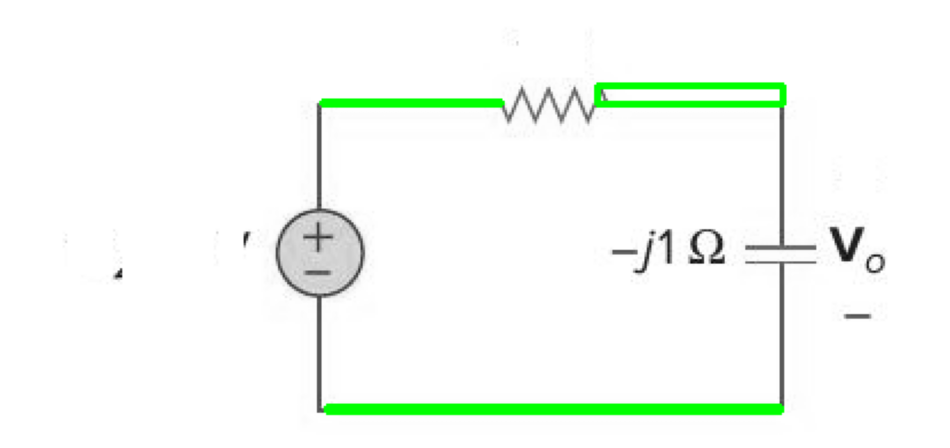

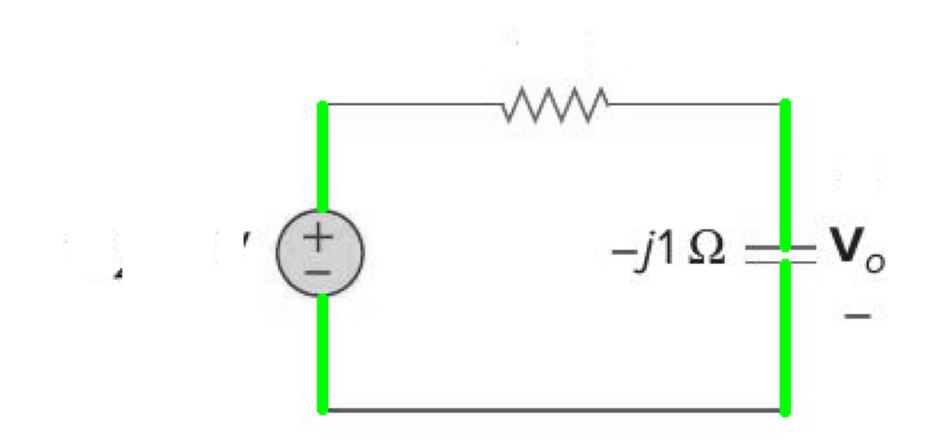

In [83]:
def get_horizontal_lines(contours, min_size = 0):
    horizontal_line_heights = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        horizontal_line_heights.append(int(y + h/2))

    return horizontal_line_heights

def get_bounding_boxes(contours):
    return list(map(cv2.boundingRect, contours))

def draw_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2):
    image_with_boxes = image.copy()
    for x, y, w, h in bounding_boxes:
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
    draw_image(image_with_boxes)

def draw_horizontal_lines_bb(image, contours, line_heights):
    # Convert image from BGR to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw red horizontal lines at the heights of detected lines
    for h in line_heights:
        print('h: ' + str(h))
        cv2.line(image_rgb, (0, h), (image_rgb.shape[1], h), (255, 0, 0), 2)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with the red lines using plt.imshow
    plt.imshow(image_rgb)
    plt.show()

bounding_boxes_horz = list(map(get_bounding_boxes, contours_horz))
draw_bounding_boxes(circuit_images[TEST_CIRCUIT], bounding_boxes_horz[TEST_CIRCUIT])

bounding_boxes_vert = list(map(get_bounding_boxes, contours_vert))
draw_bounding_boxes(circuit_images[TEST_CIRCUIT], bounding_boxes_vert[TEST_CIRCUIT])

# line_heights = get_horizontal_lines(contours_horz[TEST_CIRCUIT])
# draw_horizontal_lines_bb(circuit_images[TEST_CIRCUIT], contours_horz[TEST_CIRCUIT], line_heights)

## Merge overlapping bounding boxes.

Fixes when more than just wires are bounded by bounding boxes

In [84]:
A = [("a", "b"), ("c", "d")]
for i, (x, y) in enumerate(A):
  print(i, x, y)

0 a b
1 c d


In [1]:
def image_with_bounding_boxes(image, bounding_boxes, color=(0, 255, 0), thickness=2, labels=None):
    image_with_boxes = image.copy()
    for i, (x, y, w, h) in enumerate(bounding_boxes):
        # Put class text above the bounding box
        if labels is not None:
            print('label: ', labels[i])
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), color, thickness)
            cv2.putText(img=image_with_boxes, text=str(labels[i]), org=(x, y+h+15),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.5,
                        color=color,
                        thickness=2)
    return image_with_boxes

def intervals_overlap(intr1, intr2, reversed_call=False):
  # intr1: -------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr2[0] < intr1[1]:
    return True
  # intr1:  -----------
  # intr2:    -------
  if intr1[0] < intr2[0] and intr1[1] > intr2[1]:
    return True

  if not reversed_call:
    return intervals_overlap(intr2, intr1, True)
  else:
    return False

def union_bounding_boxes(bounding_boxes, dim):
  left = -1
  right = float("inf")
  for x, y, w, h in bounding_boxes:
    if dim == 0:
      left = max(left, x)
      right = min(right, x + w)
    else:
      left = max(left, y)
      right = min(right, y + h)

  length = right - left

  bounding_boxes_union = [
      (left, y, length, h) if dim == 0 else (x, left, w, length)
      for x, y, w, h in bounding_boxes
  ]

  return bounding_boxes_union

def merge_overlapping_bounding_boxes(bounding_boxes, dim):
  # Find overlapping intervals
  overlapping_intr_map = {}
  overlapping_intrs = set()
  non_overlapping_intrs = set(range(len(bounding_boxes)))
  for i, (x1, y1, w1, h1) in enumerate(bounding_boxes[:-1]):
    for j, (x2, y2, w2, h2) in enumerate(bounding_boxes[i+1:]):

      intr1 = None
      intr2 = None
      if dim == 0:
        intr1 = [x1, x1 + w1]
        intr2 = [x2, x2 + w2]
      elif dim == 1:
        intr1 = [y1, y1 + h1]
        intr2 = [y2, y2 + h2]
      else:
        raise Exception(f"invalid dim = {dim}")

      if intervals_overlap(intr1, intr2):
        overlapping_intrs.add(i)
        non_overlapping_intrs.discard(i)
        non_overlapping_intrs.discard(1 + i + j)
        overlapping_intr_map[i] = 1 + i + j

  #find groups of overlapping intervals
  overlapping_bounding_boxes_grouped = []
  while len(overlapping_intrs) > 0:
    intr_group = []
    cur = next(iter(overlapping_intrs))
    while True:
      intr_group.append(bounding_boxes[cur])
      overlapping_intrs.discard(cur)
      if cur in overlapping_intr_map:
        cur = overlapping_intr_map[cur]
      else:
        break
    overlapping_bounding_boxes_grouped.append(intr_group)

  # the final bounding boxes will contain all bounding boxes not overlapping
  final_bounding_boxes = [bounding_boxes[i] for i in non_overlapping_intrs]
  for overlapping_group in overlapping_bounding_boxes_grouped:
    final_bounding_boxes.extend(
        union_bounding_boxes(overlapping_group, dim)
    )

  return final_bounding_boxes

bounding_boxes_horz_merged = list(map(
    partial(merge_overlapping_bounding_boxes, dim=1),
    bounding_boxes_horz
))
bounding_boxes_vert_merged = list(map(
    partial(merge_overlapping_bounding_boxes, dim=0),
    bounding_boxes_vert
))

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_bounding_boxes(
    circuit_images[TEST_CIRCUIT].copy(),
    bounding_boxes_horz_merged[TEST_CIRCUIT]
))
axarr[1].imshow(image_with_bounding_boxes(
    circuit_images[TEST_CIRCUIT].copy(),
    bounding_boxes_vert_merged[TEST_CIRCUIT]
))

NameError: name 'partial' is not defined

## Corner Detection

##### Step 1. Use Harris Corner Detection, and filter for corners inside bounding boxes from previous step

<Figure size 640x480 with 0 Axes>

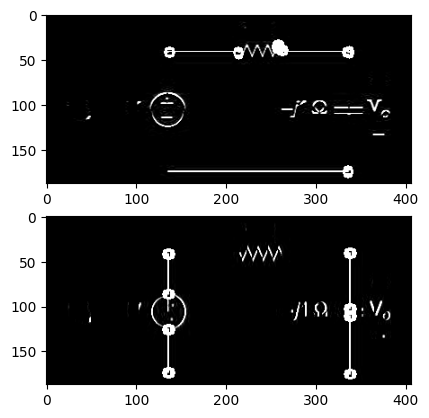

In [86]:
import cv2
import numpy as np


def get_corners(img, bounding_boxes, dim, wire_padding):
    if len(img.shape) == 2:
        # The image is grayscale. Convert it to BGR.
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Harris corner detection
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)

    # Dilate to enhance corner points
    dst = cv2.dilate(dst, None)

    # Threshold for an optimal value, it may vary depending on the image.
    corner_mask = dst > 0.1 * dst.max()

    # Get corner coordinates
    corner_coordinates = np.argwhere(corner_mask)

    # Filter corner points by checking if they are within any of the bounding boxes
    def filter_cond(x, y, box):
      if dim == 0:
        return x >= box[0] and x <= box[0] + box[2] and y >= box[1] - wire_padding and y <= box[1] + box[3] + wire_padding
      else:
        return x >= box[0] - wire_padding and x <= box[0] + box[2] + wire_padding and y >= box[1] and y <= box[1] + box[3]
    filtered_corner_coordinates = [
        (x, y)
        for y, x in corner_coordinates
        if any(
            filter_cond(x, y, box)
            for box in bounding_boxes
        )
    ]

    return filtered_corner_coordinates

corners_horz_harris = [
    get_corners(image, bounding_boxes, 0, 10)
    for image, bounding_boxes in zip(circuit_images_horz, bounding_boxes_horz_merged)
]
corners_vert_harris = [
    get_corners(image, bounding_boxes, 1, 10)
    for image, bounding_boxes in zip(circuit_images_vert, bounding_boxes_vert_merged)
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz_harris[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert_harris[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

##### Step 2. Append corners of previously found bounding boxes

corners_vert_bb
(136, 125)
(136, 175)
(338, 110)
(338, 176)
(136, 41)
(136, 87)
(338, 40)
(338, 104)


<Figure size 640x480 with 0 Axes>

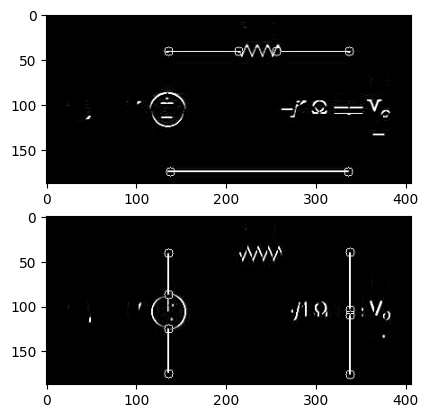

In [87]:
def get_corners_bounding_boxes(bounding_boxes, dim):
  corners = []
  for bounding_box in bounding_boxes:
    x1, y1, w1, h1 = bounding_box
    if dim == 0:
      yavg = y1 + h1 // 2
      corners += [(x1, yavg), (x1 + w1, yavg)]
    else:
      xavg = x1 + w1 // 2
      corners += [(xavg, y1), (xavg, y1 + h1)]
  return corners

corners_horz_bb = [
    get_corners_bounding_boxes(bounding_boxes, dim=0)
    for image, bounding_boxes in zip(circuit_images_horz, bounding_boxes_horz_merged)
]
corners_vert_bb = [
    get_corners_bounding_boxes(bounding_boxes, dim=1)
    for image, bounding_boxes in zip(circuit_images_vert, bounding_boxes_vert_merged)
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz_bb[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

print("corners_vert_bb")
print("\n".join(str(val) for val in corners_vert_bb[TEST_CIRCUIT]))
image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert_bb[TEST_CIRCUIT]:
# for x, y in [(121, 184)]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

#### Step 3. Merge Harris and Bounding Box corners

<Figure size 640x480 with 0 Axes>

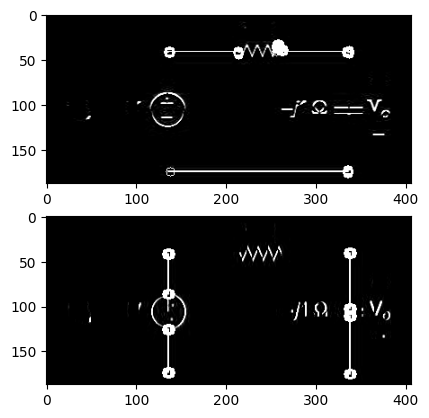

In [88]:
corners_horz = [
    corners_horz_harris[i] + corners_horz_bb[i]
    for i in range(len(corners_horz_harris))
]
corners_vert = [
    corners_vert_harris[i] + corners_vert_bb[i]
    for i in range(len(corners_horz_harris))
]

image_with_corners_horz = circuit_images_horz[TEST_CIRCUIT].copy()
for x, y in corners_horz[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_horz, (x, y), 5, (255, 0, 0), 1)
image_with_corners_horz = cv2.cvtColor(image_with_corners_horz, cv2.COLOR_BGR2RGB)

image_with_corners_vert = circuit_images_vert[TEST_CIRCUIT].copy()
for x, y in corners_vert[TEST_CIRCUIT]:
    cv2.circle(image_with_corners_vert, (x, y), 5, (255, 0, 0), 1)
image_with_corners_vert = cv2.cvtColor(image_with_corners_vert, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_with_corners_horz)
axarr[1].imshow(image_with_corners_vert)

#### Step 4. Delete corners in both vertical and horizontal

<Figure size 640x480 with 0 Axes>

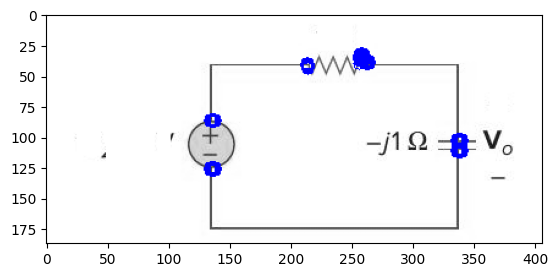

In [89]:
def euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def combined_list(A, B, threshold):
    F = A + B
    for a in A:
        for b in B:
            if euclidean_distance(a, b) < threshold:
                if a in F: F.remove(a)
                if b in F: F.remove(b)

    return F

corners = [
    combined_list(corners_horz_i, corners_vert_i, 10)
    for corners_horz_i, corners_vert_i in zip(corners_horz, corners_vert)
]

image_with_corners = circuit_images[TEST_CIRCUIT].copy()
for x, y in corners[TEST_CIRCUIT]:
    cv2.circle(image_with_corners, (x, y), 5, (255, 0, 0), 1)
image_with_corners = cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,1)
axarr.imshow(image_with_corners)

### Cluster corner points + filter to find component locations



Steps

1.   Run cluster algorithm
2.   Compute
```
avg_dist = 0
for p in cluster:
  avg_dist += dist(p, centroid)
```
3. If this average is too small, throw away cluster. This is clearly not a component it is too small


<Figure size 640x480 with 0 Axes>

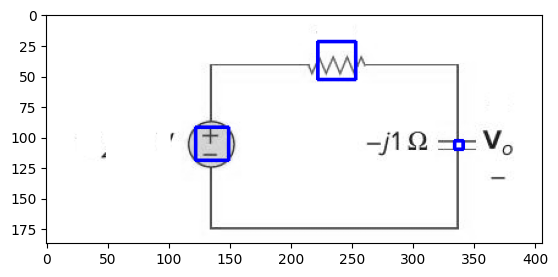

In [90]:
from sklearn.cluster import DBSCAN
import numpy as np

def euclidian_std(points, mean_point):
  # Compute squared differences from the mean
  squared_diffs = (points - mean_point)**2

  # Compute mean of squared differences
  variance = np.mean(squared_diffs)

  # Compute standard deviation as square root of variance
  return np.sqrt(variance)

def get_center_of_points(points):
  min_values = np.min(points, axis=0)
  max_values = np.max(points, axis=0)
  return (max_values + min_values)/2

def merge_close_points(F, distance_threshold, stddev_threshold):
    if len(F) == 0: return F

    # Perform DBSCAN on F with the specified distance threshold
    clustering = DBSCAN(eps=distance_threshold, min_samples=1).fit(F)

    # Create a list to hold the averaged points
    averaged_points = []

    # For each cluster label, average the points in that cluster
    for cluster_id in set(clustering.labels_):
        # Get the points in the current cluster
        cluster_points = np.array([F[i] for i in range(len(F)) if clustering.labels_[i] == cluster_id])

        # Compute the mean of the points in the cluster
        mean_point = get_center_of_points(cluster_points)

        stddev = euclidian_std(cluster_points, mean_point)

        # Check if the maximum standard deviation across dimensions is below the threshold
        if np.max(stddev) >= stddev_threshold and len(cluster_points) > 1:
            # Compute the centroid of the cluster and append to the averaged points list
            centroid = mean_point
            averaged_points.append((
                (int(centroid[0]), int(centroid[1])),
                stddev
            ))

    return averaged_points

corners_join_nearby = [
    merge_close_points(corners_i, 46, 1)
    for corners_i in corners
]

image_with_corners = circuit_images[TEST_CIRCUIT].copy()
for (x, y), radius_cluster in corners_join_nearby[TEST_CIRCUIT]:
    radius = radius_cluster
    top_left = (int(x - radius), int(y - radius))
    bottom_right = (int(x + radius), int(y + radius))
    cv2.rectangle(image_with_corners, top_left, bottom_right, (255, 0, 0), 2)
image_with_corners = cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB)

plt.figure()
f, axarr = plt.subplots(1,1)
axarr.imshow(image_with_corners)

## Create bounding boxes around each component


## Use SIFT to classify bounding boxes


label:  bbox_0
label:  bbox_1
label:  bbox_2


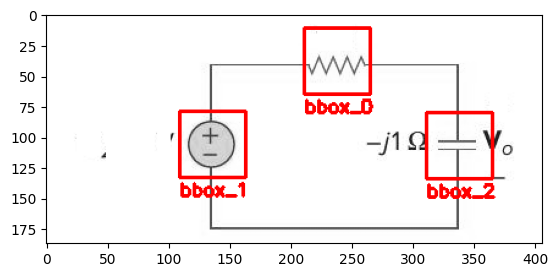

In [91]:
def build_bounding_box_from_clusters(clusters_info):
    if len(clusters_info) == 0: return []

    max_radius = int(1.8 * max(radius for _, radius in clusters_info))
    return [
        (x - max_radius, y - max_radius, 2*max_radius, 2*max_radius)
        for (x, y), radius_cluster in clusters_info
    ]

bounding_boxes_components = [
    build_bounding_box_from_clusters(clusters_info)
    for clusters_info in corners_join_nearby
]

plt.figure()
plt.imshow(image_with_bounding_boxes(
    circuit_images[TEST_CIRCUIT].copy(),
    bounding_boxes_components[TEST_CIRCUIT],
    labels=[f'bbox_{i}' for i in range(len(bounding_boxes_components[TEST_CIRCUIT]))],
    color=(255,0,0)
))

### Load example component images

current_source


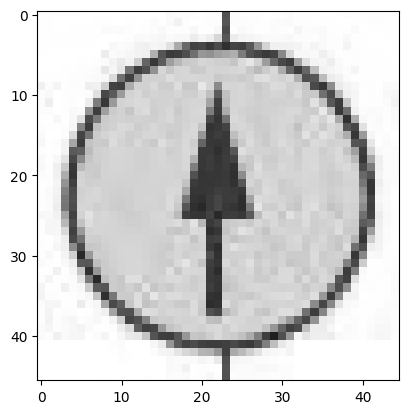

In [92]:
EXAMPLE_COMPONENTS_DIR = '/content/drive/MyDrive/Photo_Circuit/data/example_components'

import cv2
import os
import glob

# Get a list of all image file paths in the directory
image_paths = glob.glob(os.path.join(EXAMPLE_COMPONENTS_DIR, '*.png'))

# Load all images into an array
component_images = [cv2.imread(image_path) for image_path in image_paths]
component_names = [image_path.split('/')[-1].split('.')[0] for image_path in image_paths]

print(component_names[0])
plt.imshow(component_images[0])

### Find Interest Points of components

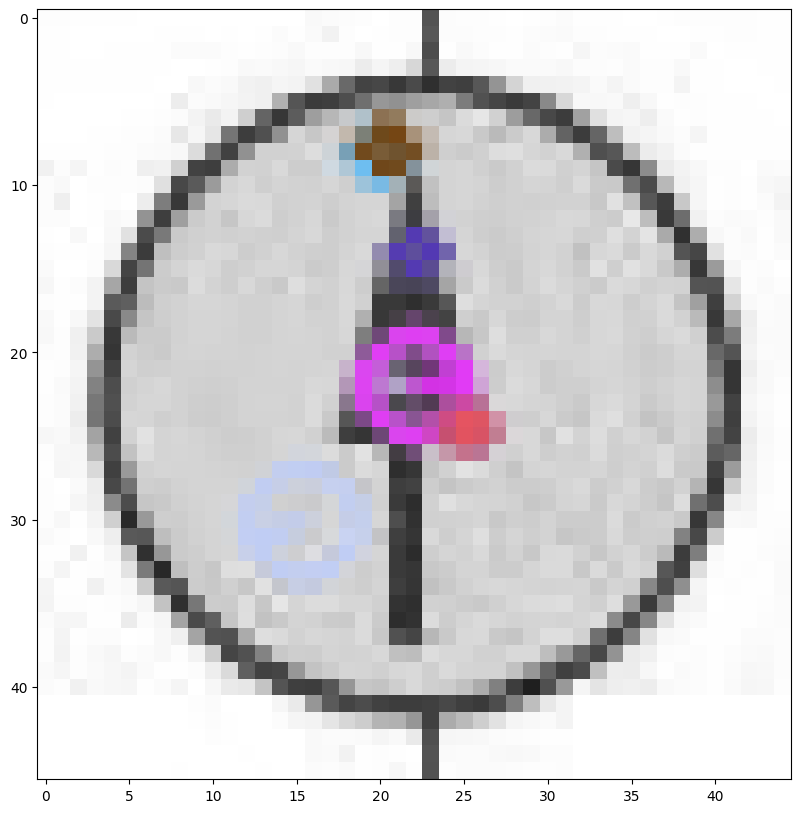

In [93]:
def sift_get_keypoints_descriptors(image):
  # Convert the image to gray scale
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Create a SIFT object
  sift = cv2.SIFT_create()

  # Detect SIFT features, with no masks
  keypoints, descriptors = sift.detectAndCompute(gray, None)

  return keypoints, descriptors

components_interest_points = [
    sift_get_keypoints_descriptors(image) for image in component_images
]

image_drawn = cv2.drawKeypoints(component_images[0], components_interest_points[0][0], outImage=None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(image_drawn, cv2.COLOR_BGR2RGB))
plt.show()

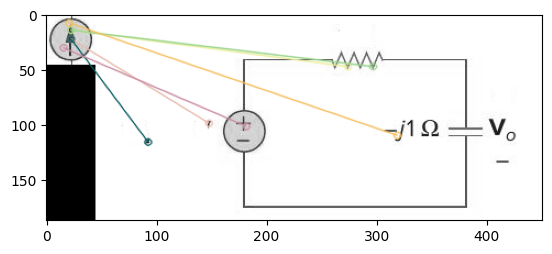

In [94]:
import cv2
import numpy as np

# Load the template and the circuit image
template = component_images[0]  # grayscale
circuit = circuit_images[TEST_CIRCUIT]  # grayscale

# Create a SIFT object
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors for template and circuit
keypoints_template, descriptors_template = sift.detectAndCompute(template, None)
keypoints_circuit, descriptors_circuit = sift.detectAndCompute(circuit, None)

# Use a Brute-Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_template, descriptors_circuit)

# Sort matches based on distance (the lower the better)
matches = sorted(matches, key=lambda x: x.distance)

# Initialize a mask to draw only the keypoints inside the bounding box
# mask = np.zeros(circuit.shape, dtype=bool)
# mask[y1:y2, x1:x2] = True

# # Filter matches that fall inside the bounding box
# matches_in_bbox = [m for m in matches if mask[int(keypoints_circuit[m.trainIdx].pt[1]), int(keypoints_circuit[m.trainIdx].pt[0])]==True]

# Draw the matches
result = cv2.drawMatches(template, keypoints_template, circuit, keypoints_circuit, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
plt.imshow(result)


### Find Matches for all components in images

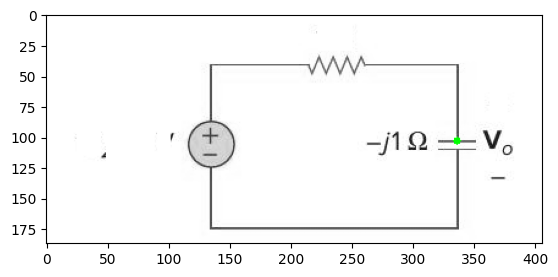

In [95]:
def get_matches_for_all_components_in_image(circuit_image):
  global component_names
  global components_interest_points

  # Use a Brute-Force matcher
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

  # Interest Points in circuit
  keypoints_circuit, descriptors_circuit = sift.detectAndCompute(circuit_image, None)

  component_match_points = {}

  for component_name, sift_get_keypoints_descriptor in zip(component_names, components_interest_points):
    descriptors_comp = sift_get_keypoints_descriptor[1]

    # Match descriptors
    matches = bf.match(descriptors_circuit, descriptors_comp)

    # Sort matches based on distance (the lower the better)
    matches = sorted(matches, key=lambda x: x.distance)

    matches_points = [(int(keypoints_circuit[m.queryIdx].pt[0]), int(keypoints_circuit[m.queryIdx].pt[1])) for m in matches]

    component_match_points[component_name] = matches_points

  return component_match_points

circuits_match_points_by_component = [get_matches_for_all_components_in_image(circuit_image) for circuit_image in circuit_images]

# Draw a small circle (dot) on each point
image = circuit_images[TEST_CIRCUIT].copy()
for point in circuits_match_points_by_component[TEST_CIRCUIT]["capacitor"]:
    cv2.circle(image, point, 3, (0, 255, 0), -1)

# Display the image
plt.imshow(image)

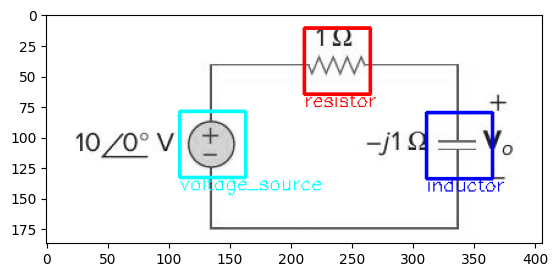

In [96]:
def classify_boxes_using_sift(
    circuit_match_points_by_component,
    bounding_boxes_components_circuit
  ):
  bbox_classes = []

  # loop over component bounding boixes in circuit
  for x_bbox, y_bbox, w_bbox, h_bbox in bounding_boxes_components_circuit:

    # at first, the best fit component is unknown. If no match points are found
    # for any components it will remain unknown
    max_matching_points = 0
    best_fit_component_name = "unknown"

    # loop over components + match points for each component in circuit image
    for component_name, component_match_points in circuit_match_points_by_component.items():

      # True if (x,y) is in bbox
      inside_bbox = lambda x, y: (x_bbox <= x <= x_bbox + w_bbox) and (y_bbox <= y <= y_bbox + h_bbox)
      match_count = sum(1 for x_match, y_match in component_match_points if inside_bbox(x_match, y_match))

      # more match points in this bounding box for this component, update best_fit_component_name
      if match_count > max_matching_points:
        max_matching_points = match_count
        best_fit_component_name = component_name

    # mark that best_fit_component_name for this bbox
    bbox_classes.append(best_fit_component_name)

  return bbox_classes


circuits_bbox_classifications = [
    classify_boxes_using_sift(circuit_match_points_by_component, bounding_boxes_components_circuit)
    for circuit_match_points_by_component, bounding_boxes_components_circuit in zip(circuits_match_points_by_component, bounding_boxes_components)
]

circuit_num = TEST_CIRCUIT
# circuit_num = 1
color_mapping = {
    "resistor": (255, 0, 0),        # Red
    "capacitor": (0, 255, 0),       # Green
    "inductor": (0, 0, 255),        # Blue
    "voltage_source": (0, 255, 255), # Yellow
    "current_source": (255, 0, 255)
}
image = raw_circuit_images[circuit_num].copy()
# Loop through classes and bounding boxes
for cls, bbox in zip(circuits_bbox_classifications[circuit_num], bounding_boxes_components[circuit_num]):
    x, y, w, h = bbox

    color = color_mapping[cls] if cls in color_mapping else (0,0,0)

    # Draw rectangle (bounding box)
    cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)

    # Put class text above the bounding box
    cv2.putText(img=image, text=cls, org=(x, y+h+10),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=color,
                thickness=1)

# Display the image
plt.imshow(image)

## Use special handling to find capacitors

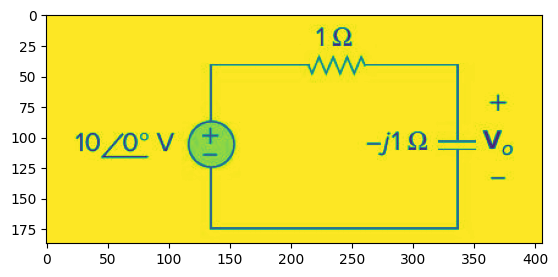

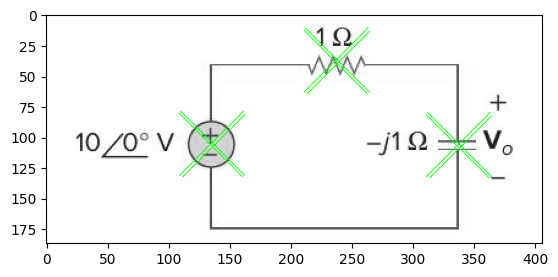

In [97]:
import cv2
import numpy as np
import math

def line_length(line):
    x1, y1, x2, y2 = line[0]
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def are_parallel(line1, line2, threshold_angle):
    x1, y1, x2, y2 = line1[0]
    x3, y3, x4, y4 = line2[0]
    angle1 = math.degrees(math.atan2(y2 - y1, x2 - x1))
    angle2 = math.degrees(math.atan2(y4 - y3, x4 - x3))
    return abs(angle1 - angle2) < threshold_angle

# Load your image
image = raw_circuit_images[TEST_CIRCUIT].copy()
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# sharpen_kernel = np.array([[0, -1, 0],
#                    [-1, 5,-1],
#                    [0, -1, 0]])
# image_grey = cv2.filter2D(image_grey, -1, sharpen_kernel)
plt.imshow(image_grey)
plt.figure()

# Assume bounding_boxes is a list of bounding boxes in the form (x, y, w, h)
bounding_boxes = bounding_boxes_components[TEST_CIRCUIT]

for bbox in bounding_boxes:
  x, y, w, h = bbox
  min_length = 0.3 * min(w, h)  # minimum length of line
  roi = image_grey[y:y+h, x:x+w]  # region of interest

  # Apply edge detection
  edges = cv2.Canny(roi, 50, 150, apertureSize=3)

  # plt.imshow(edges)
  # plt.figure()

  # Apply Hough Line Transform
  lines = cv2.HoughLinesP(roi, 1, np.pi/180, 100, minLineLength=50, maxLineGap=100)

  if lines is None:
    print("no lines found")
    continue

  # Draw lines on the image
  for line in lines:
      x1, y1, x2, y2 = line[0]
      x1 += x
      x2 += x
      y1 += y
      y2 += y
      cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(image)
